In [2]:
# Name: Ara Kris Ütücü.
# ID:   24062.


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import seaborn as sns  # a visualization library based on matplotlib
from datetime import datetime
import reverse_geocoder as r
import reverse_geocoder as rg
from geopy.distance import geodesic as g

import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")

%matplotlib inline


In [4]:
taxi = pd.read_csv("taxi-trips.csv")

In [5]:
taxi['pickup_district'] = [i['name'] for i in r.search(
    list(zip(
        taxi.pickup_latitude, 
        taxi.pickup_longitude)))]

taxi['dropoff_district'] = [i['name'] for i in r.search(
    list(zip(
        taxi.dropoff_latitude, 
        taxi.dropoff_longitude)))]


Loading formatted geocoded file...


Manhattan           45329
New York City       34625
Long Island City    17787
Weehawken           11334
The Bronx            2777
Name: pickup_district, dtype: int64


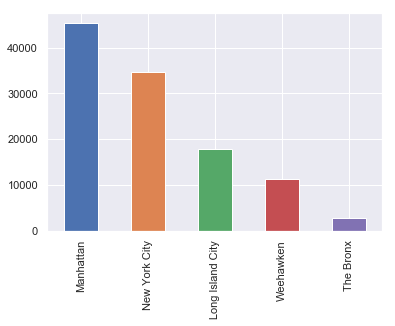

In [6]:
pickup_districts = taxi.pickup_district.value_counts()
print(pickup_districts[:5])
pickup_districts.head(5).plot(kind='bar')


Manhattan           44478
New York City       31082
Long Island City    19919
Weehawken           10621
Brooklyn             2059
Name: dropoff_district, dtype: int64


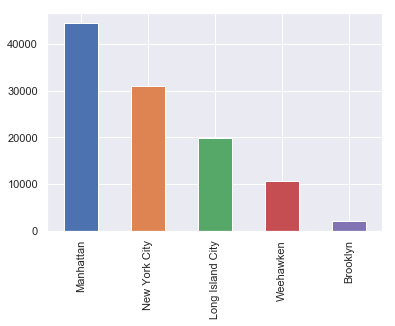

In [7]:
dropoff_districts = taxi.dropoff_district.value_counts()
print(dropoff_districts[:5])
dropoff_districts.head(5).plot(kind='bar')


In [8]:
taxi['distance'] = [ g(i,j).kilometers 
                    for i,j in zip(
                        zip(taxi.pickup_latitude, 
                            taxi.pickup_longitude),
                        zip(taxi.dropoff_latitude, 
                            taxi.dropoff_longitude))]

In [9]:
import datetime
def parse_time(dtime):
    return datetime.datetime.strptime(dtime,'%Y-%m-%d %H:%M:%S')

def parse(dtime):
    d = parse_time(dtime)
    h = d.hour
    if 0 <= h < 7:
        return "late night"
    elif 7 <= h < 9:
        return "rush hour morning"
    elif 9 <=h < 16:
        return "after noon"
    elif 16 <= h < 18:
        return "rush hour evening"
    elif h < 23:
        return "evening"
    else:
        return "late night"
    
taxi['time'] = [parse(i) for i in taxi.pickup_datetime]

In [10]:
taxi['duration'] = [(parse_time(i)-parse_time(j)).total_seconds()/60 
                    for i,j in zip(taxi.dropoff_datetime,taxi.pickup_datetime)]

                time  distance
0         after noon  3.109986
1            evening  3.378136
2         late night  4.117635
3  rush hour evening  3.342814
4  rush hour morning  3.128280


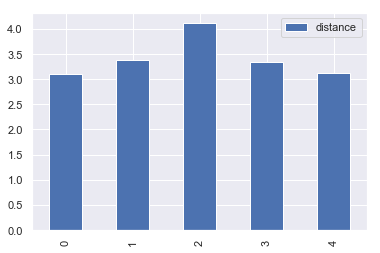

In [11]:
mean_dist = taxi[['distance','time']].groupby(['time'], as_index=False).mean()
print(mean_dist)
mean_dist.plot(kind='bar')

                time   duration
0         after noon  16.065379
1            evening  14.893255
2         late night  14.434924
3  rush hour evening  17.074909
4  rush hour morning  15.308145


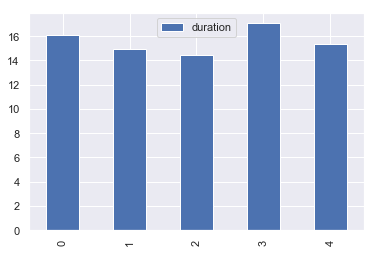

In [12]:
mean_dur = taxi[['duration','time']].groupby(['time'], as_index=False).mean()
print(mean_dur)
mean_dur.plot(kind='bar')

In [13]:
#single customers have shorter distance, p<0.05
from scipy.stats import ttest_ind
single = taxi.passenger_count<=1;
couple = taxi.passenger_count>1;

print (taxi[single].duration.mean(), taxi[couple].duration.mean())
ttest = ttest_ind(taxi[single].distance, taxi[couple].distance)

p = ttest[1]

if p >= 0.05:
    print ('Null Cannot Be Rejected')
else:
    print ('Reject Null Hypothesis!')

14.973369633988142 16.64640640522481
Reject Null Hypothesis!


In [14]:
def isweekday(d):
    return parse_time(d).weekday()<=4

from scipy.stats import ttest_ind
weekday = [isweekday(i) for i in taxi.pickup_datetime]
weekend = [isweekday(i)==0 for i in taxi.pickup_datetime]
# in weekdays customers had gone longer distances 
# p is less than 0.05, so we rejected the hypothesis
print (taxi[weekday].duration.mean(), taxi[weekend].duration.mean())

ttest = ttest_ind(taxi[weekday].distance, taxi[weekend].distance)
p = ttest[1]

if p >= 0.05:
    print ('Null Cannot Be Rejected')
else:
    print ('Reject Null Hypothesis!')

15.687140044646261 14.890360277313633
Reject Null Hypothesis!
